### Import data

In [1]:
using DrugResponseModel

# import data from the path
conc_l, pop, g2, g1, g2_0, g1_0 = setup_data("lapatinib");# in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0

┌ Info: Precompiling DrugResponseModel [f46a7e40-ab32-11e9-0ff4-0323d592fbfd]
└ @ Base loading.jl:1273


### Estimate 

In [2]:
# ODE optimization and estimation of the parameters
params_ode = zeros(4, 8)
for i in 1:8
    params_ode[:, i] = ODEoptimizer(zeros(4), 2.0*ones(4), [1.0, 1.0, 0.0, 0.0], i, g1, g2, g1_0, g2_0)
end

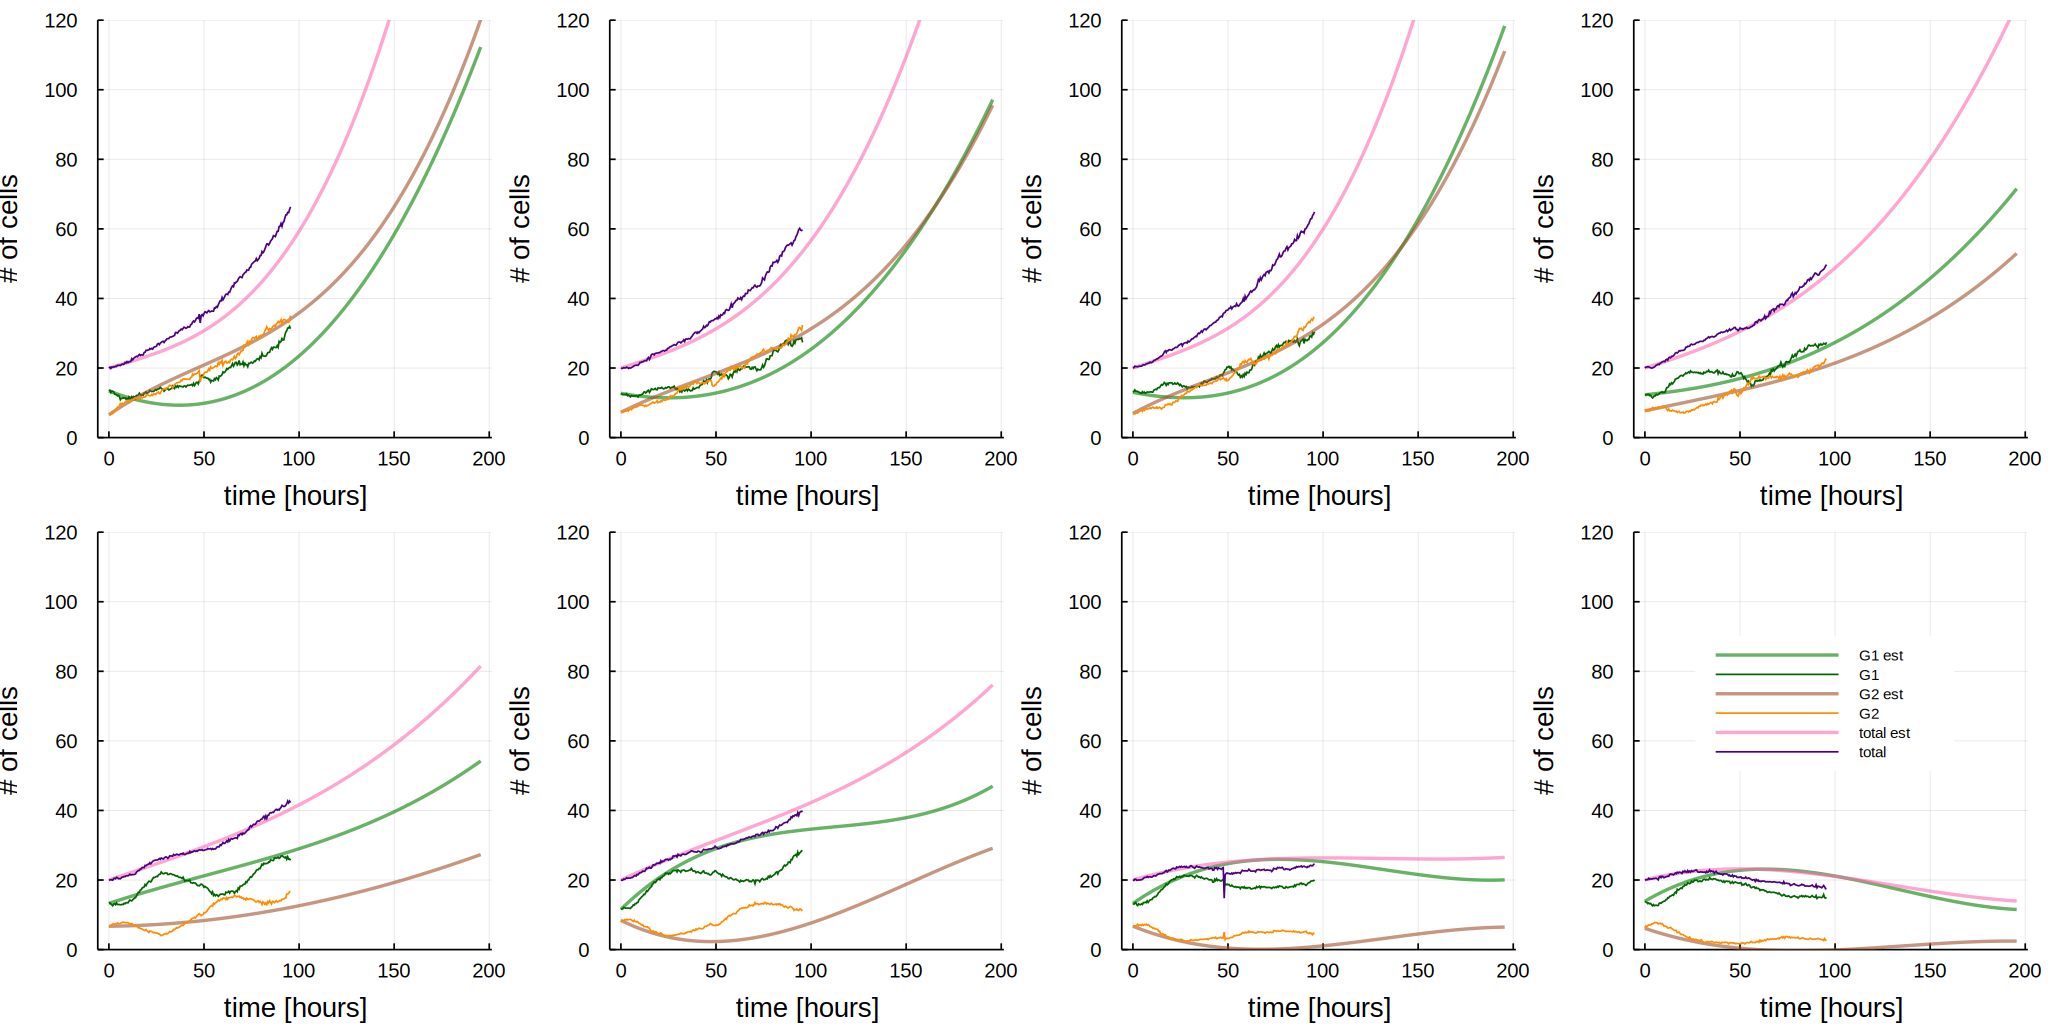

In [3]:
# plotting the fitted curves
ODEplot_all(params_ode, g1, g2, g1_0, g2_0, pop)